# Анализ маркетинговых показателей  Яндекс.Афиши

Цель: снизить маркетинговые расходы — отказаться от невыгодных источников трафика для перераспределения бюджета

Необходимо изучить:
* как клиенты пользуются сервисом,
* когда делают первые покупки на сайте,
* сколько денег приносит компании каждый клиент,
* когда расходы на привлечение клиента окупаются.

Выборка: данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* информация по заказам за этот период,
* статистика рекламных расходов.

Выручка измеряется в условных единицах — у.е.

# Общая информация

## Исследование и предобработка данных 

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st

In [ ]:
#открываем 

url1 = "https://drive.google.com/file/d/.../view?usp=sharing"
url2 = "https://drive.google.com/file/d/.../view?usp=sharing"
url3 = "https://drive.google.com/file/d/.../view?usp=sharing"

costs = pd.read_csv('https://drive.google.com/uc?id=' + url1.split('/')[-2])
orders_log = pd.read_csv('https://drive.google.com/uc?id=' + url2.split('/')[-2])
visits_log = pd.read_csv('https://drive.google.com/uc?id=' + url3.split('/')[-2])


In [ ]:
print('Общая информация о наборе данных \n')

def info(data):
  print('Размер таблицы: {}\n'.format(data.shape), '\n')
  #data.info()
  print('Количество пропусков: \n', data.isnull().sum(), '\n')
  print('Тип данных: \n', data.dtypes, '\n')
  display(data.sample(4, random_state=1))

info(costs)
info(orders_log)
info(visits_log)

Общая информация о наборе данных 

Размер таблицы: (2542, 3)
 

Количество пропусков: 
 source_id    0
dt           0
costs        0
dtype: int64 

Тип данных: 
 source_id      int64
dt            object
costs        float64
dtype: object 



,source_id,dt,costs
1481,5,2017-06-30,77.88
1833,9,2017-06-18,9.44
2045,9,2018-01-16,13.90
1785,5,2018-05-01,79.99


Размер таблицы: (50415, 3)
 

Количество пропусков: 
 Buy Ts     0
Revenue    0
Uid        0
dtype: int64 

Тип данных: 
 Buy Ts      object
Revenue    float64
Uid         uint64
dtype: object 



,Buy Ts,Revenue,Uid
7271,2017-09-09 01:29:00,1.10,7674233352595996409
36523,2018-02-23 08:56:00,1.71,8129244829733440960
41828,2018-03-25 16:47:00,1.22,9003018755281849036
39266,2018-03-10 11:51:00,4.28,775704491445963998


Размер таблицы: (359400, 5)
 

Количество пропусков: 
 Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64 

Тип данных: 
 Device       object
End Ts       object
Source Id     int64
Start Ts     object
Uid          uint64
dtype: object 



,Device,End Ts,Source Id,Start Ts,Uid
167589,desktop,2018-01-15 21:12:00,10,2018-01-15 21:06:00,11898993694310850933
299103,desktop,2018-05-09 01:21:00,4,2018-05-09 01:21:00,7218061394456444803
345632,desktop,2018-02-18 20:17:00,3,2018-02-18 20:12:00,5663226520415784959
91779,touch,2018-05-14 16:08:00,4,2018-05-14 16:07:00,10927064994254891814


Пропусков в данных нет.

Во всех датафреймах необходимо перевести формат даты и времени из строки в datetime. 

В названиях столбцов таблиц расходов и заказов заменим пробелы на нижнее подчеркивание и переведем к нижнему регистру для более удобного обращения к ним

In [ ]:
# приведем в порядок названия столбцов
orders_log.columns = orders_log.columns.str.lower().str.replace(" ", "_")
visits_log.columns = visits_log.columns.str.lower().str.replace(" ", "_")

In [ ]:
# переведем столбцы с датами к коллектному формату
costs['dt'] = pd.to_datetime(costs['dt'])
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'])
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'])
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'])

In [ ]:
# проверка
print('Тип данных costs: \n', costs.dtypes, '\n')
print('Тип данных orders_log: \n', orders_log.dtypes, '\n')
print('Тип данных visits_log: \n', visits_log.dtypes, '\n')

Тип данных costs: 
 source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object 

Тип данных orders_log: 
 buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object 

Тип данных visits_log: 
 device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object 



Иных ошибок нет.

# Метрики и визуализации

## Продуктовые метрики

### DAU, WAU и MAU

Вычислите средние значения этих метрик за весь период. Отобразите изменения метрик во времени на графиках

In [ ]:
# выделим параметры времении для опредления метрик 

visits_log['session_month'] = visits_log['start_ts'].astype('datetime64[M]')
visits_log['session_week']  = visits_log['start_ts'].astype('datetime64[W]')
visits_log['session_date'] = visits_log['start_ts'].astype('datetime64[D]')

In [ ]:
visits_log.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27


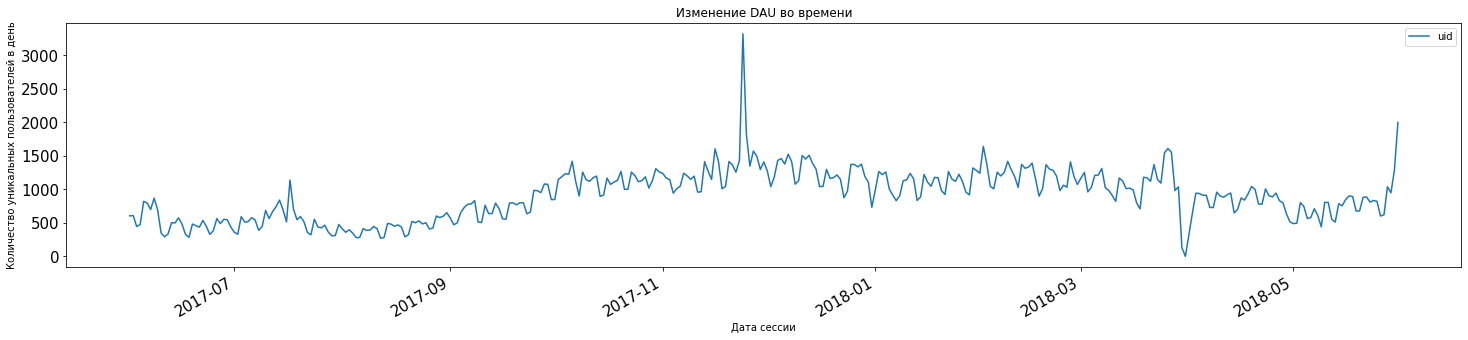

Среднее значение DAU за весь период: 907


In [ ]:
#DAU — количество уникальных пользователей в день
dau = visits_log.groupby('session_date').agg({'uid': 'nunique'})
dau_total = dau.mean()

dau.plot(figsize=(25, 5), title="Изменение DAU во времени" , fontsize = 15)
plt.xlabel('Дата сессии')
plt.ylabel('Количество уникальных пользователей в день')
plt.show()
print('Среднее значение DAU за весь период:', int(dau_total))

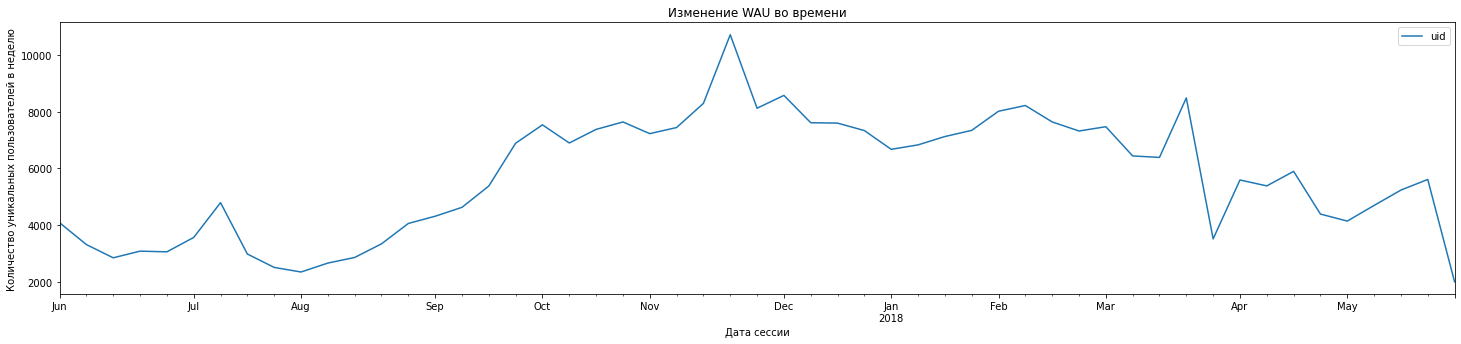

Среднее значение WAU за весь период: 5724


In [ ]:
#WAU — количество уникальных пользователей в неделю

wau = visits_log.groupby(['session_week']).agg({'uid': 'nunique'})
wau_total = wau.mean()

wau.plot(figsize=(25, 5), title="Изменение WAU во времени")
plt.xlabel('Дата сессии')
plt.ylabel('Количество уникальных пользователей в неделю')
plt.show()
print('Среднее значение WAU за весь период:', int(wau_total))

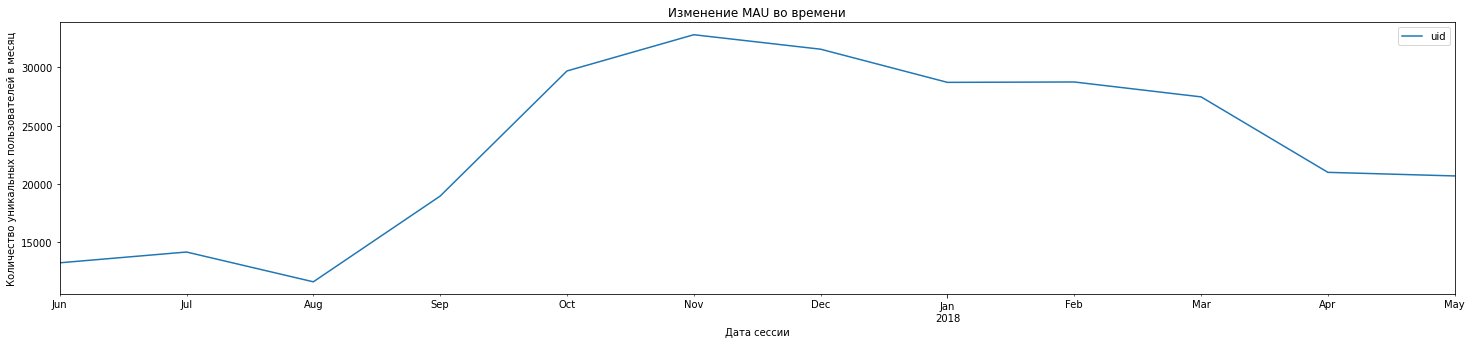

Среднее значение MAU за весь период: 23228


In [ ]:
#MAU — количество уникальных пользователей в месяц

mau = visits_log.groupby(['session_month']).agg({'uid': 'nunique'})
mau_total = mau.mean()

mau.plot(figsize=(25, 5), title="Изменение MAU во времени")
plt.xlabel('Дата сессии')
plt.ylabel('Количество уникальных пользователей в месяц')
plt.show()
print('Среднее значение MAU за весь период:', int(mau_total))

### Частота посещения сайта

Определите, сколько раз за день пользователи в среднем заходят на сайт. 
Постройте график, отражающий изменения метрики во времени

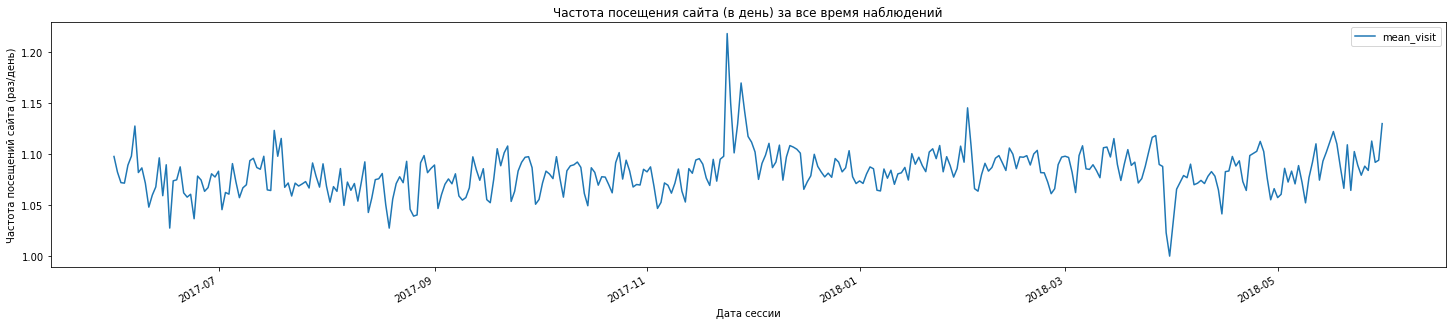

В среднем один уникальный пользователь заходит на сайт 1.082 раз в день


In [ ]:
visit_per_day = visits_log.groupby('session_date').agg({'uid': ['nunique', 'count']})

visit_per_day.set_axis(['uid', 'visit_count'], axis = 'columns', inplace=True)
visit_per_day['mean_visit'] = visit_per_day[('visit_count')] / visit_per_day['uid']
visit_per_day.drop(['visit_count', 'uid'], axis = 1, inplace=True)
visit_per_day.plot(figsize=(25, 5), title="Частота посещения сайта (в день) за все время наблюдений")
plt.xlabel('Дата сессии')
plt.ylabel('Частота посещений сайта (раз/день)')
plt.show()
print('В среднем один уникальный пользователь заходит на сайт {} раз в день'.format(round(visit_per_day['mean_visit'].mean(), 3)))

ВЫВОД

На последнем графике можно проследить общую тенденцию к повышению частоты посещения сайта во второй половине 2017 года: примерно с 500 до 1200/день. Выделяется отдельный пик в декабре (4042 посещений) (можно предположить, что это связано с новогодними празниками и повышенной покупательской активностью)

До апреля 2018 показатели достаточно стабильны и сравнимы с показателями октября-ноября 2017: 1200 посещений в день.
В апреле есть резкий провал в статистике посещений. Как возможная причина, недоступность сайта из-за тех.причин. После этого и средняя частота посещений снизилась до 600 посещений в день.

Расчет продуктовых метрик за весь период наблюдений показал:

* DAU = 907
* WAU = 5724
* MAU = 23228

В среднем один уникальный пользователь заходит на сайт 1.082 раз в день

### Длительность сессии

Исследуйте, сколько времени пользователи проводят на сайте. Узнайте продолжительность типичной пользовательской сессии за весь период. 

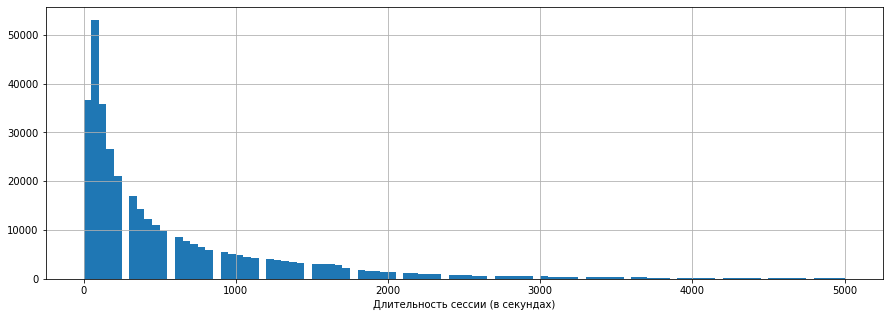

In [ ]:
# добавим столбец с расчетом длительности сессии
visits_log['session_duration_sec'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds

# посмотрим на распределение
visits_log['session_duration_sec'].hist(bins=100, figsize=(15, 5), range=[0, 5000])
plt.xlabel('Длительность сессии (в секундах)')
plt.show()


In [ ]:
# для определения средней меры используем моду, т.к распределение далеко от нормального
asl = visits_log['session_duration_sec'].mode()
print('Чаще всего (по моде) пользователи проводят {} секунд на сайте'.format(int(asl)))

Чаще всего (по моде) пользователи проводят 60 секунд на сайте


In [ ]:
print('Средняя продолжительность сессии, мин:', round((visits_log['session_duration_sec'].mean())/60, 1))
print('Медианная продолжительность сессии, мин:', round((visits_log['session_duration_sec'].median())/60, 1))

Средняя продолжительность сессии, мин: 10.7
Медианная продолжительность сессии, мин: 5.0


Медиана менее чувствительна к выбросам, поэтому, можно полагать, что в среднем пользоатели проводият 5 мин на сайте. Все же, не слишком много.

Гипотезы, почему так мала средняя продолжительность сессии:
- пользователь заранее посмотрел,что купить, пришла зарплата и он купил
- пришло напоминание о "брошенной" корзине

### Retention Rate

Расчет с применением когортного анализа. 

Покажите изменения метрики во времени на графике. Найдите средний Retention Rate на второй месяц «жизни» когорт.

In [ ]:
# определим дату первого визита (first_visit_month) и дополним сведениями таблицу visits_log

first_visit_month_by_customers = visits_log.groupby(['uid'])['session_month'].min()
first_visit_month_by_customers.name = 'first_visit_month'
visits_log = visits_log.join(first_visit_month_by_customers, on='uid')

In [ ]:
# Найдём время жизни lifetime для когорт

visits_log['cohort_lifetime'] = ((visits_log['session_month'] - visits_log['first_visit_month']) / 
                                                np.timedelta64(1, 'M')).round().astype('int')

In [ ]:
# сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей по месяцам

cohorts_visits = visits_log.groupby(['first_visit_month','cohort_lifetime']).agg(
    {'uid': ['count', 'nunique']}).reset_index()

In [ ]:
cohorts_visits.set_axis(['first_visit_month', 'cohort_lifetime','visit_count', 'uid'], 
                 axis = 'columns', inplace=True)

In [ ]:
# Найдём исходное количество пользователей в когорте
initial_users_count = cohorts_visits[cohorts_visits['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
# переименуем столбец
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
# объединим таблицы
cohorts_visits = cohorts_visits.merge(initial_users_count, on='first_visit_month')
# вычислим коэффициент удержания
cohorts_visits['retention'] = cohorts_visits['uid']/cohorts_visits['cohort_users']

In [ ]:
# для удобства восприятия оставим только месяц и год 
cohorts_visits['first_visit_month'] = cohorts_visits['first_visit_month'].dt.strftime('%Y-%m')

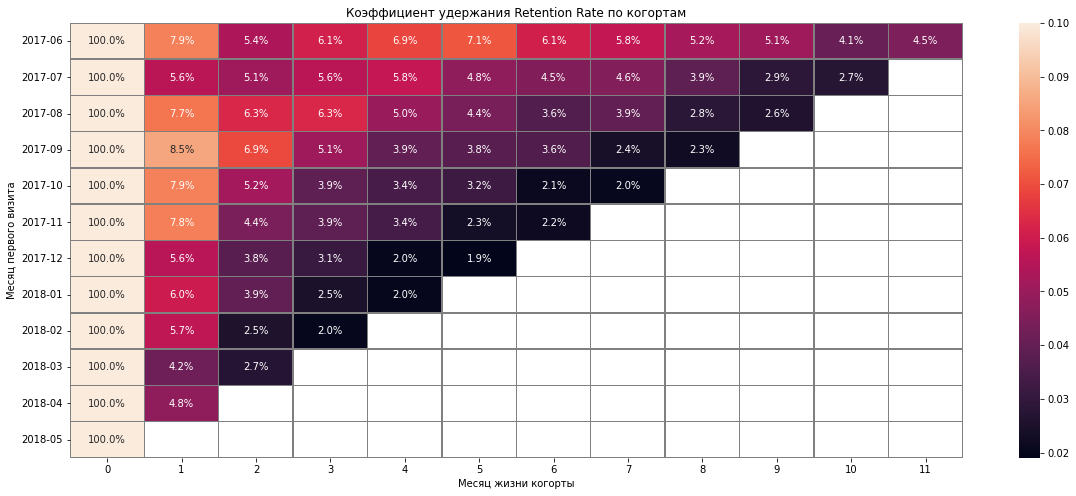

Cредний Retention Rate(%) на второй месяц «жизни» когорт: 6.52


In [ ]:
# визуализируем

retention_pivot = cohorts_visits.pivot_table(
    index='first_visit_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum')

plt.figure(figsize=(20, 8))
plt.title("Коэффициент удержания Retention Rate по когортам")
sns.heatmap(retention_pivot, annot=True, fmt='.1%', vmax=0.1, 
            linewidths=0.4, linecolor='grey') 
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Месяц первого визита')
plt.show()

print('Cредний Retention Rate(%) на второй месяц «жизни» когорт:', 
      round(cohorts_visits.query('cohort_lifetime ==1')['retention'].mean() * 100, 2))

ВЫВОД

В основном визиты очень короткие: всего 5 мин проводят пользователи на сайте. 

Постоянных пользователей совсем немного. Уже на второй месяц возвращается 6,5% покупателей. Кажется, что раньше пользователям больше нравился сервис: клиенты из более старых когорт 2017 возвращались чаще и коэф.удержания для них на 6 месяце жизни сравним с коэф.удержания новых клиентов из когорт 2018.

Можно отметить, что чуть больше, чем обычно, когорты 06-2017, 08-11.2017 возвращались за билетами, особенно, перед новым годом, после чего активность затухала.

Стоит ли задуматься о том, что мы редко ходим в кино или театр?:)

## Метрики электронной коммерции

### Время для принятия решения о покупке

Сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки?

In [ ]:
# первое посещение сайта
first_visits_date_by_customers = visits_log.groupby('uid')['start_ts'].min()
first_visits_date_by_customers.name = 'first_visit_date'
visits_log = visits_log.join(first_visits_date_by_customers, on='uid')

# определим дату первой покупки (first_order_date) и дополним сведениями таблицу orders_log
first_order_date_by_customers = orders_log.groupby(['uid'])['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'
orders_log = orders_log.join(first_order_date_by_customers, on='uid')


In [ ]:

# объединим таблицы визитов и заказов
visits_orders = visits_log.merge(first_order_date_by_customers, on='uid')
visits_orders = visits_orders[['uid', 'start_ts', 'end_ts', 'session_duration_sec', 'first_visit_date', 'first_order_date']]


# время между первым посещением сайта и первым заказом (в секундах)
visits_orders['time_to_order'] = ((visits_orders['first_order_date'] - 
                                   visits_orders['first_visit_date']) / 
                                  np.timedelta64(1, 'D')).round().astype('int')

display(visits_orders.sample(10, random_state=1))

,uid,start_ts,end_ts,session_duration_sec,first_visit_date,first_order_date,time_to_order
16972,6243553978752835767,2018-05-01 13:03:00,2018-05-01 13:24:00,1260,2018-02-16 23:42:00,2018-03-09 09:43:00,20
78304,11534679928349161250,2017-12-16 13:47:00,2017-12-16 14:16:00,1740,2017-12-16 13:47:00,2017-12-16 14:11:00,0
95778,11928831391252577071,2017-09-29 04:13:00,2017-09-29 04:13:19,19,2017-09-29 04:13:00,2017-09-29 04:13:00,0
39613,11755280862298027331,2018-02-13 15:28:00,2018-02-13 15:32:00,240,2017-12-28 11:43:00,2018-01-02 20:48:00,5
30978,10963793192217036581,2017-07-13 04:05:00,2017-07-13 04:25:00,1200,2017-07-13 04:05:00,2017-11-10 10:51:00,120
94955,158793031270652516,2017-09-21 10:54:00,2017-09-21 11:20:00,1560,2017-09-21 10:40:00,2017-09-21 14:21:00,0
16377,13652851766069131673,2017-11-01 08:30:00,2017-11-01 08:31:00,60,2017-06-01 09:03:00,2017-12-29 23:05:00,212
55818,15824820941334536629,2018-01-11 23:24:00,2018-01-11 23:32:00,480,2017-07-20 22:29:00,2017-07-20 22:36:00,0
88349,1111059291436994008,2018-02-20 23:31:00,2018-02-20 23:31:00,0,2018-02-20 18:40:00,2018-02-20 23:31:00,0
26716,17339642338984417372,2017-09-09 22:03:00,2017-09-09 22:53:00,3000,2017-07-08 14:45:00,2018-02-04 02:23:00,210


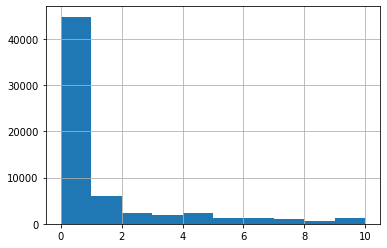

In [ ]:
visits_orders['time_to_order'].hist(bins = 10, range = (0, 10))
plt.show()

In [ ]:
print('Чаще всего с момента первого посещения сайта до совершения покупки проходит {} день'.
      format(int(visits_orders['time_to_order'].median())))

Чаще всего с момента первого посещения сайта до совершения покупки проходит 1 день


### Среднее количество покупок

расчет среднего количества покупок на одного покупателя за период с применением когортного анализа

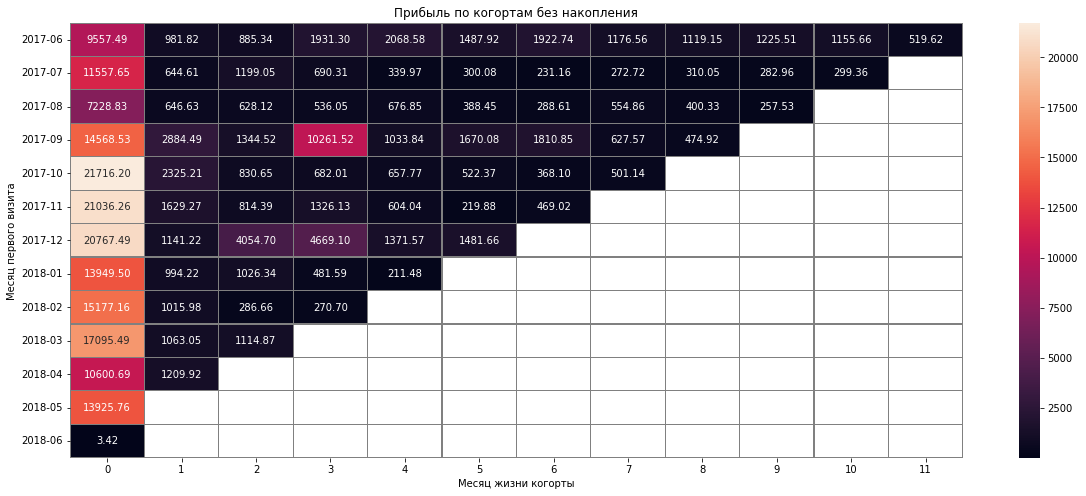

In [ ]:
# сформируем когорты по таблице заказов

# учитывая тот факт, что исследуемая выборка дана за год, когорты следует разбивать по месяцам

orders_log['order_month'] = orders_log['buy_ts'].astype('datetime64[M]')
orders_log['first_order_month'] = orders_log['first_order_date'].astype('datetime64[M]')

# Найдём время жизни lifetime для когорт

orders_log['cohort_lifetime'] = ((orders_log['order_month'] - orders_log['first_order_month']) / 
                                                np.timedelta64(1, 'M')).round().astype('int')

# для удобства восприятия оставим только месяц и год 
orders_log['order_month'] = orders_log['order_month'].dt.strftime('%Y-%m')
orders_log['first_order_month'] = orders_log['first_order_month'].dt.strftime('%Y-%m')

# сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей по месяцам

cohorts = orders_log.groupby(['first_order_month','cohort_lifetime']).agg(
    {'uid': ['count', 'nunique'], 'revenue': 'sum'}).reset_index()

cohorts.set_axis(['first_order_month', 'cohort_lifetime','order_count', 'uid', 'revenue_sum'], 
                 axis = 'columns', inplace=True)

# Найдём исходное количество пользователей в когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_order_month', 'uid']]
# переименуем столбец
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
# объединим таблицы
cohorts = cohorts.merge(initial_users_count, on='first_order_month')

cohorts_revenue = cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue_sum',
    aggfunc='sum')
# визуализируем
plt.figure(figsize=(20, 8))
plt.title('Прибыль по когортам без накопления')
sns.heatmap(cohorts_revenue, annot=True, fmt='.2f', 
            linewidths=0.2, linecolor='grey') 
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Месяц первого визита')
plt.show()

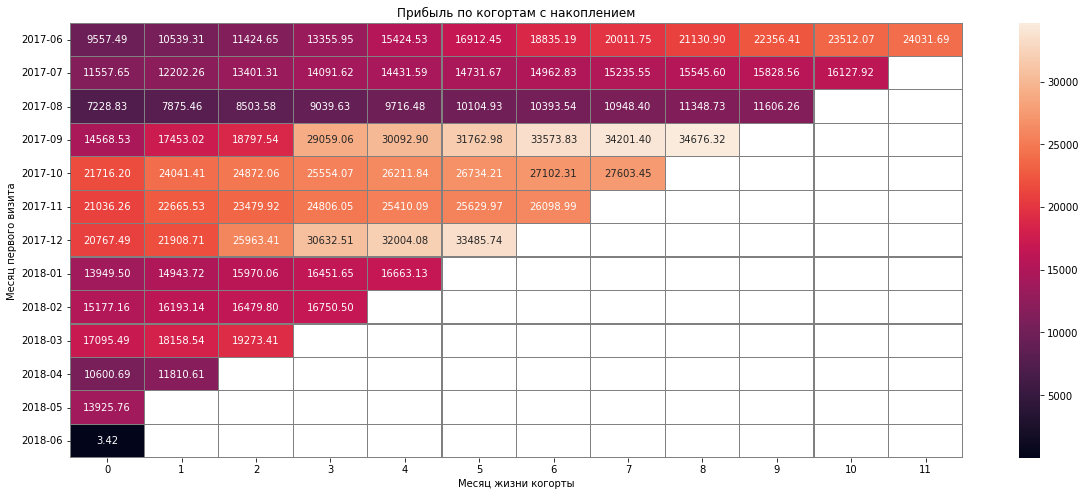

In [ ]:
cohorts_revenue_cumsum = cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue_sum',
    aggfunc='sum').cumsum(axis=1)
# визуализируем
plt.figure(figsize=(20, 8))
plt.title('Прибыль по когортам с накоплением')
sns.heatmap(cohorts_revenue_cumsum, annot=True, fmt='.2f', 
            linewidths=0.2, linecolor='grey') 
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Месяц первого визита')
plt.show()

In [ ]:
# рассчитаем среднее количество покупок на одного покупателя

cohorts['order_per_user'] = (cohorts['order_count'] / cohorts['cohort_users']) 

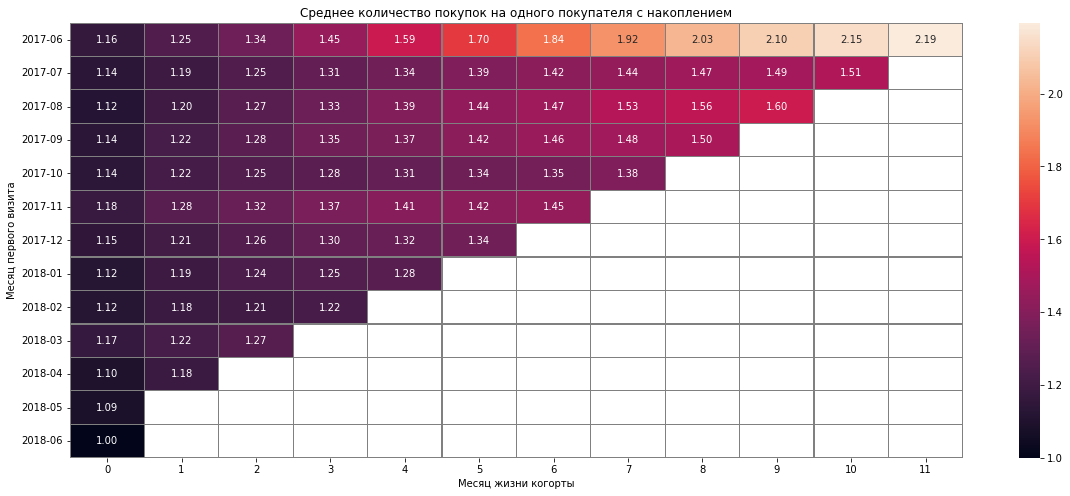

In [ ]:
order_per_user_pivot = cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='order_per_user',
    aggfunc='mean').cumsum(axis=1)

# визуализируем
plt.figure(figsize=(20, 8))
plt.title('Среднее количество покупок на одного покупателя c накоплением')
sns.heatmap(order_per_user_pivot, annot=True, fmt='.2f', 
            linewidths=0.2, linecolor='grey') 
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Месяц первого визита')
plt.show()

### Средний чек

Рассчет среднего чека с применением группировки по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. 


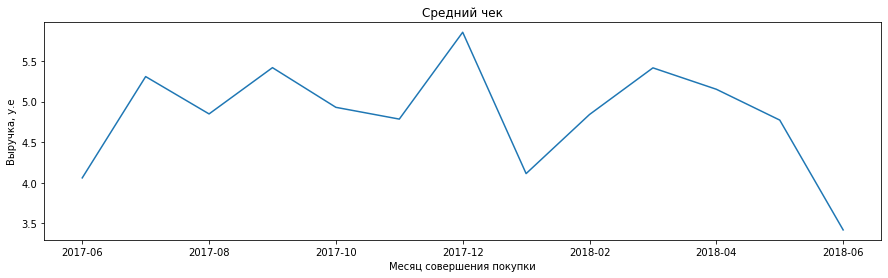

In [ ]:
orders_log.groupby('order_month')['revenue'].mean().plot(
    figsize=(15, 4), title="Cредний чек")
plt.xlabel('Месяц совершения покупки')
plt.ylabel('Выручка, у.е')
plt.show()

### LTV на покупателя по когортам

LTV — накопительная метрика. 
Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. 
Маржинальность сервиса — 100%. 

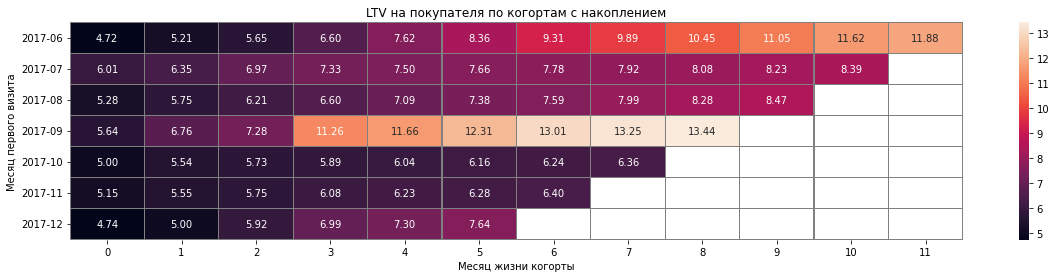

In [ ]:
#поскольку маржинальность сервиса — 100%, то сумма заказов (revenue) равна валовой прибыли
cohorts['ltv'] = cohorts['revenue_sum'] / cohorts['cohort_users']
result = cohorts.query('first_order_month <= "2017-12"').pivot_table(
    index='first_order_month', columns='cohort_lifetime', values='ltv', aggfunc='mean').cumsum(axis=1).round(2)
result.fillna('') 

# визуализируем
plt.figure(figsize=(20, 4))
plt.title('LTV на покупателя по когортам c накоплением')
sns.heatmap(result, annot=True, fmt='.2f', 
            linewidths=0.2, linecolor='grey') 
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Месяц первого визита')
plt.show()

In [ ]:
# средний LTV для 6 месячных когорт
round(result[5].mean(),2)

7.97

ВЫВОД

Как уже отмечалось, в декабре, перед новым годом, и посещений сайта, и покупок было больше, чем обычнно. Вырос и средний чек.
Все это скомпенсировалсь экономией в январе.

Самой активной когортой можно назвать покупателей, пришедших в июне 2016.
Однако, рассчитав LTV, видим, что покупатели 09-2017 принесли сервису куда больше прибыли уже к декабрю 2017, чем когорта 06-2017 (LTV)

Клиенты, пришедшие в декабре (12-2017), вернулись с прибылью в феврале и марте (увеличение общей суммы покупок в 4 раза). Учитывая факт того, что в среднем товаров было куплено примерно столько же, а RR даже несколько снизился, значит, суммы покупок стали больше.


## Маркетинговые метрики

Посчитайте и отобразите на графиках, как маркетинговые метрики различаются по рекламным источникам. 
Один и тот же пользователь мог заходить на сайт из нескольких источников, поэтому важно определить «главный» источник для каждого и учитывать это в расчётах. Например, главным может стать первый источник перехода


### Общая сумма расходов на маркетинг

Как траты распределены по источникам? Визуализируйте изменения метрик во времени

In [ ]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]').dt.strftime('%Y-%m') 

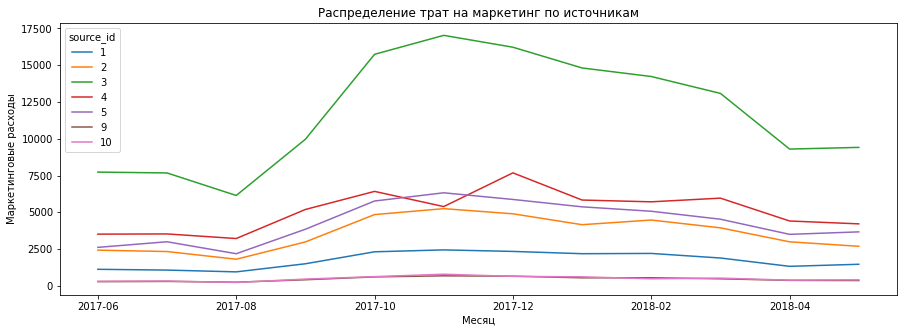

Общая сумма расходов на маркетинг: 329131.62


In [ ]:
#расходы по источникам

costs_pivot = costs.pivot_table(index='dt_month', columns = 'source_id', values='costs', aggfunc='sum')

costs_pivot.plot(figsize=(15, 5), title="Распределение трат на маркетинг по источникам")
plt.xlabel('Месяц')
plt.ylabel('Маркетинговые расходы')
plt.show()
print('Общая сумма расходов на маркетинг:', costs['costs'].sum())


Явный фаворит у маркетологов - источник 3. На него, по-видимму, сделаны ставки и прведены активные траты с сентября по декабрь. Что ж, мы видели выше, что пользовательская активность действительно росла в этот период.
Пиком вложений в источник 3 стал ноябрь, далее до апреля компания снижала затраты.

В то же время, примерно в равных размерах были вложены средства в каналы продаж 2, 4, 5.
В меньшей мере - в 1.

Источники 9 и 10 не поддерживались отдельно. Бюджет на них практически не расходуется.

Общая сумма расходов на маркетинг: 329131.62 у.е.

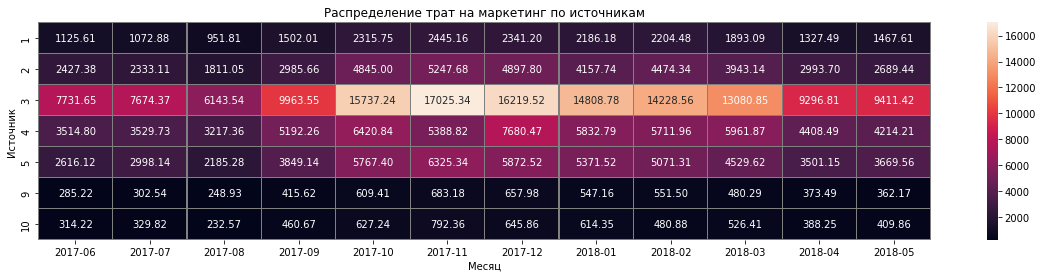

In [ ]:
costs_pivot_table = costs.pivot_table(index='source_id', columns = 'dt_month', values='costs', aggfunc='sum')
plt.figure(figsize=(20, 4))
plt.title('Распределение трат на маркетинг по источникам')
sns.heatmap(costs_pivot_table, annot=True, fmt='.2f', 
            linewidths=0.2, linecolor='grey') 
plt.xlabel('Месяц')
plt.ylabel('Источник')
plt.show()

### Средний CAC 

на одного покупателя для всего проекта и для каждого источника трафика. 

In [ ]:
# считаем расходы за месяц
monthly_costs = costs.groupby('dt_month')['costs'].sum()
# Добавим данные о расходах в отчёт 
cohorts = pd.merge(
    cohorts, monthly_costs, left_on='first_order_month', right_on='dt_month'
)

In [ ]:
# и посчитаем CAC
cohorts['cac'] = cohorts['costs'] / cohorts['cohort_users']
cohorts.head()

,first_order_month,cohort_lifetime,order_count,uid,revenue_sum,cohort_users,order_per_user,ltv,costs,cac
0,2017-06,0,2354,2023,9557.49,2023,1.163618,4.724414,18015.0,8.905091
1,2017-06,1,177,61,981.82,2023,0.087494,0.485329,18015.0,8.905091
2,2017-06,2,174,50,885.34,2023,0.086011,0.437637,18015.0,8.905091
3,2017-06,3,226,54,1931.30,2023,0.111715,0.954671,18015.0,8.905091
4,2017-06,4,292,88,2068.58,2023,0.144340,1.022531,18015.0,8.905091


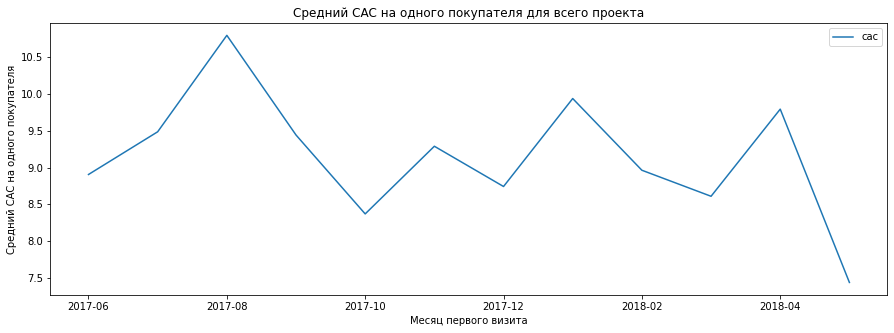

CAC на одного покупателя для всего проекта: 9.01


In [ ]:
# визуализируем
cac = cohorts.pivot_table(index='first_order_month', values='cac')

cac.plot(figsize=(15, 5), title="Cредний CAC на одного покупателя для всего проекта")
plt.xlabel('Месяц первого визита')
plt.ylabel('Cредний CAC на одного покупателя')
plt.show()
print('CAC на одного покупателя для всего проекта:', round(costs['costs'].sum() / orders_log['uid'].nunique(), 2))

In [ ]:
#выделим для каждого пользователя первый источник перехода и будем считать его главным
first_source = visits_log.sort_values(by='start_ts')
first_source = first_source.groupby('uid')['source_id'].first()

In [ ]:
# добавим информацию об источнике перехода в таблицу заказов
orders_log = orders_log.join(first_source, on='uid')
orders_log.head(10)

,buy_ts,revenue,uid,first_order_date,order_month,first_order_month,cohort_lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06,2017-06,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06,2017-06,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06,2017-06,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06,2017-06,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06,2017-06,0,3
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06,2017-06,0,3
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00,2017-06,2017-06,0,5
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06,2017-06,0,1
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01 09:22:00,2017-06,2017-06,0,4
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01 09:23:00,2017-06,2017-06,0,1


In [ ]:
# сгруппируем данные по first_order_month, lifetime и source_id. 
cohorts_new = orders_log.groupby(['first_order_month','cohort_lifetime', 'source_id']).agg({'uid': ['count', 'nunique'], 'revenue': 'sum'}).reset_index()
cohorts_new.set_axis(['first_order_month', 'cohort_lifetime', 'source_id', 'order_count', 'uid', 'revenue_sum'], axis = 'columns', inplace=True)

In [ ]:
# Посчитаем для каждой когорты и источника перехода количество активных пользователей по месяцам
initial_users_count_new = cohorts_new[cohorts_new['cohort_lifetime'] == 0][['first_order_month', 'source_id', 'uid']]
# переименуем столбец
initial_users_count_new = initial_users_count_new.rename(columns={'uid':'cohort_users'})
# объединим таблицы
cohorts_new = cohorts_new.merge(initial_users_count_new, on=['first_order_month', 'source_id'])

In [ ]:
#поскольку маржинальность сервиса — 100%, то сумма заказов (revenue) равна валовой прибыли
cohorts_new['ltv'] = cohorts_new['revenue_sum'] / cohorts_new['cohort_users']

In [ ]:
# считаем расходы за месяц c учетом источников 
monthly_costs_new = costs.groupby(['dt_month', 'source_id'])['costs'].sum()
monthly_costs_new.reset_index()

,dt_month,source_id,costs
0,2017-06,1,1125.61
1,2017-06,2,2427.38
2,2017-06,3,7731.65
3,2017-06,4,3514.80
4,2017-06,5,2616.12
...,...,...,...
79,2018-05,3,9411.42
80,2018-05,4,4214.21
81,2018-05,5,3669.56
82,2018-05,9,362.17


In [ ]:
# Добавим данные о расходах в отчёт 
cohorts_new = pd.merge(
    cohorts_new, monthly_costs_new, left_on=['first_order_month', 'source_id'], right_on=['dt_month', 'source_id']
)
# и посчитаем CAC
cohorts_new['cac'] = cohorts_new['costs'] / cohorts_new['cohort_users']
cohorts_new.head(15)

,first_order_month,cohort_lifetime,source_id,order_count,uid,revenue_sum,cohort_users,ltv,costs,cac
0,2017-06,0,1,268,190,1378.70,190,7.256316,1125.61,5.924263
1,2017-06,1,1,80,16,414.98,190,2.184105,1125.61,5.924263
2,2017-06,2,1,87,10,419.43,190,2.207526,1125.61,5.924263
3,2017-06,3,1,119,9,714.24,190,3.759158,1125.61,5.924263
4,2017-06,4,1,114,12,811.20,190,4.269474,1125.61,5.924263
5,2017-06,5,1,90,15,389.34,190,2.049158,1125.61,5.924263
6,2017-06,6,1,106,9,490.48,190,2.581474,1125.61,5.924263
7,2017-06,7,1,71,11,479.23,190,2.522263,1125.61,5.924263
8,2017-06,8,1,88,8,432.15,190,2.274474,1125.61,5.924263
9,2017-06,9,1,57,7,316.30,190,1.664737,1125.61,5.924263


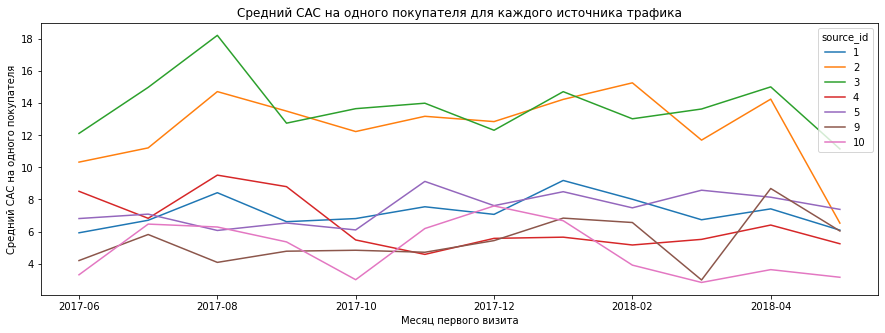

In [ ]:
# визуализируем
cac_for_source = cohorts_new.pivot_table(index='first_order_month', columns='source_id', values='cac')

cac_for_source.plot(figsize=(15, 5), title="Cредний CAC на одного покупателя для каждого источника трафика")
plt.xlabel('Месяц первого визита')
plt.ylabel('Cредний CAC на одного покупателя')
plt.show()

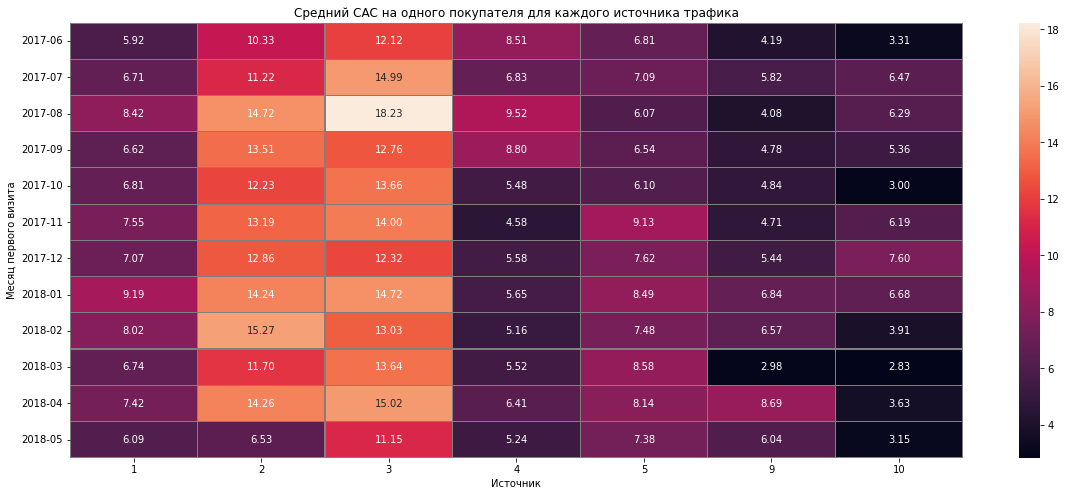

In [ ]:
# визуализируем 
plt.figure(figsize=(20, 8))
plt.title("Cредний CAC на одного покупателя для каждого источника трафика")
sns.heatmap(cac_for_source, annot=True, fmt='.2f', 
            linewidths=0.2, linecolor='grey') 
plt.xlabel('Источник')
plt.ylabel('Месяц первого визита')
plt.show()

### ROMI по когортам в разрезе источников

Сравните окупаемость за одинаковые периоды жизни когорт. 

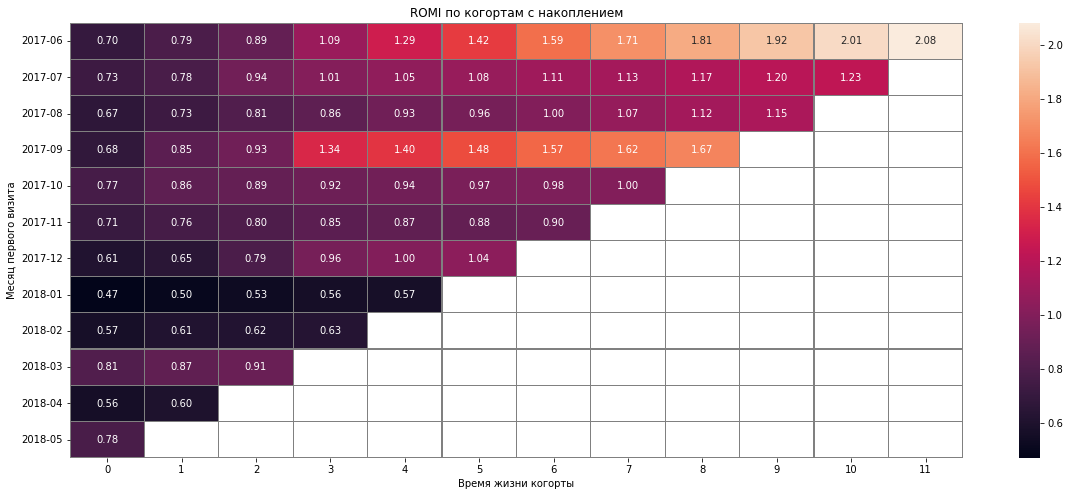

In [ ]:
cohorts_new['romi'] = cohorts_new['ltv'] / cohorts_new['cac']
output = cohorts_new.pivot_table(
    index='first_order_month', columns='cohort_lifetime', values='romi', aggfunc='mean').cumsum(axis=1).round(2) 

output.fillna('') 

# визуализируем (для начала в целом по проекту)
plt.figure(figsize=(20, 8))
plt.title('ROMI по когортам c накоплением')
sns.heatmap(output, annot=True, fmt='.2f', 
            linewidths=0.2, linecolor='grey') 
plt.xlabel('Время жизни когорты')
plt.ylabel('Месяц первого визита')
plt.show()

In [ ]:
# посчитаем среднюю когорту

output.mean(axis=0) 

cohort_lifetime
0     0.671667
1     0.727273
2     0.811000
3     0.913333
4     1.006250
5     1.118571
6     1.191667
7     1.306000
8     1.442500
9     1.423333
10    1.620000
11    2.080000
dtype: float64

В целом, на 4-5 месяце когорты начинает окупаться.

В топ-3 можно отнести когорты 06, 07 и 09-2017. Их ROMI на 4 месяце равен 1.09, 1.02 и 1.34, соответственно.

Привлеченные клиенты в январе и феврале 2018 на 4-5 месяце едва приближаются к значению ROMI 0.6.

In [ ]:
# ROMI по когортам в разрезе источников

def romi(source):
  output = cohorts_new.loc[cohorts_new.source_id == source].pivot_table(
      index='first_order_month', columns='cohort_lifetime', values='romi', aggfunc='mean').cumsum(axis=1).round(2) 
  output.fillna('') 
  plt.figure(figsize=(20, 8))
  plt.title('ROMI по когортам c накоплением по источнику ' + str(source))
  sns.heatmap(output, annot=True, fmt='.2f', 
              linewidths=0.2, linecolor='grey') 
  plt.xlabel('Время жизни когорты')
  plt.ylabel('Месяц первого визита')
  plt.show()

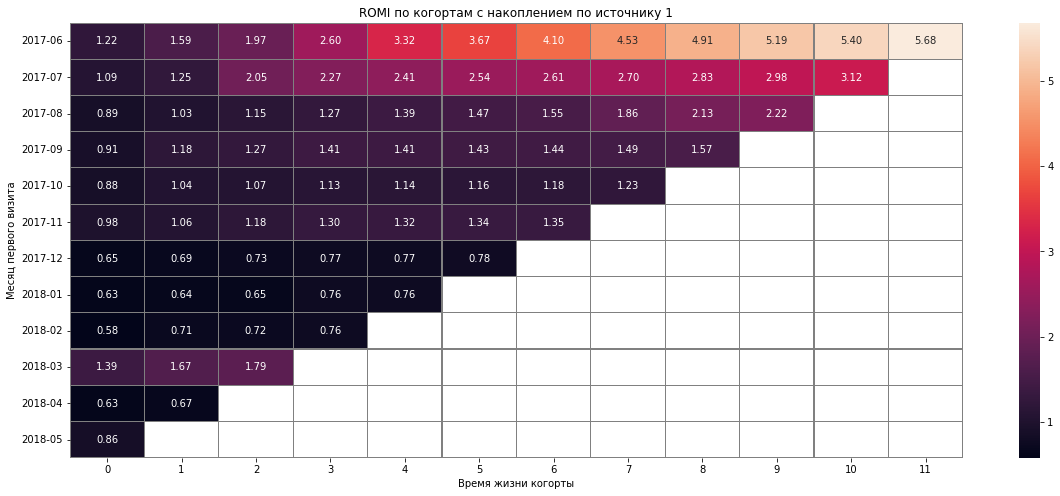

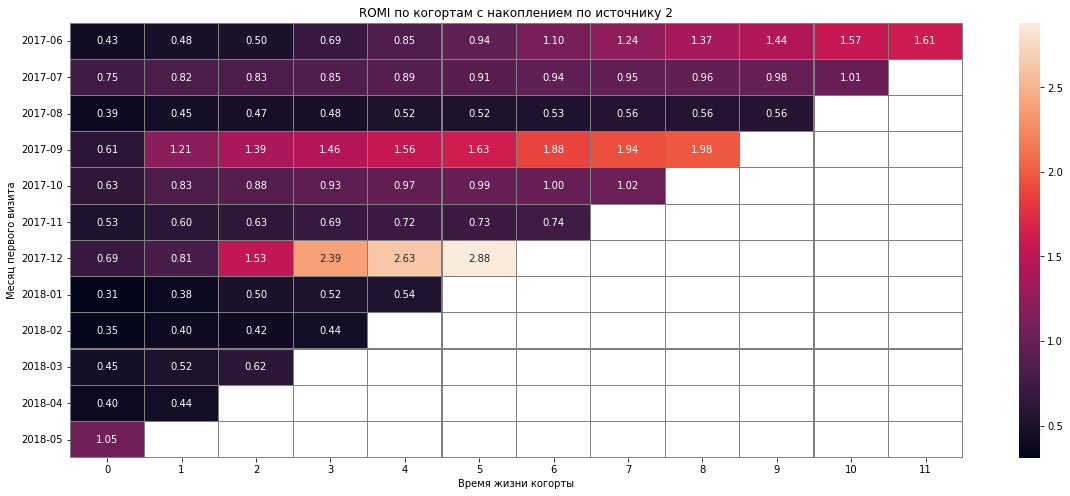

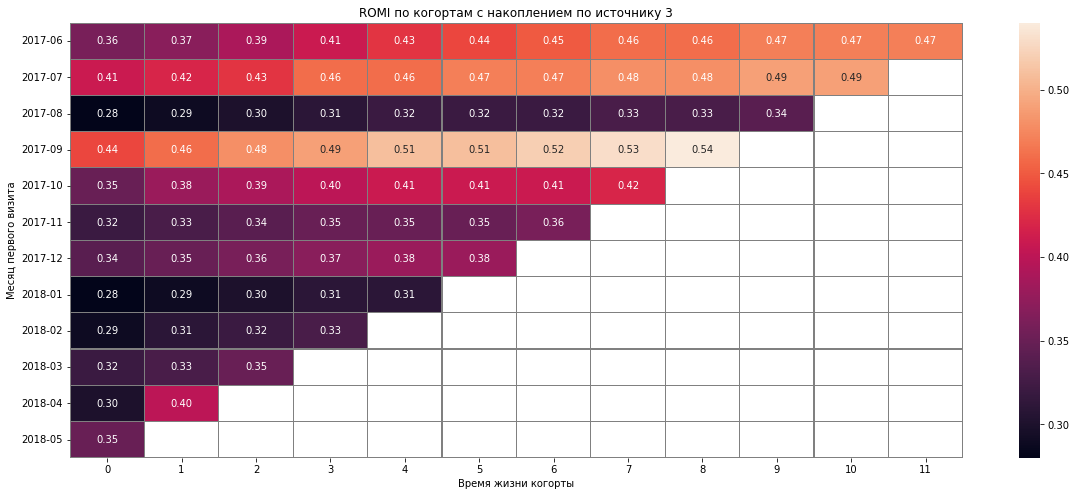

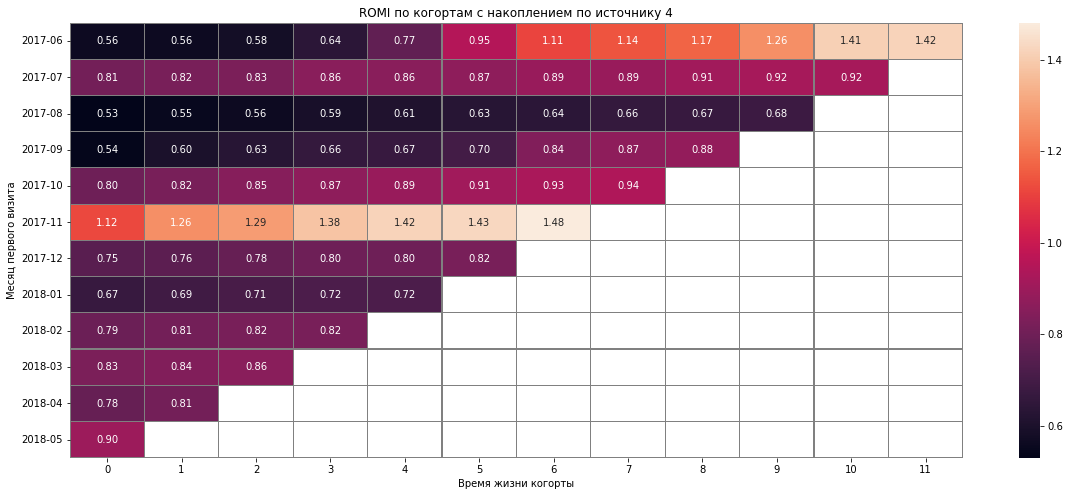

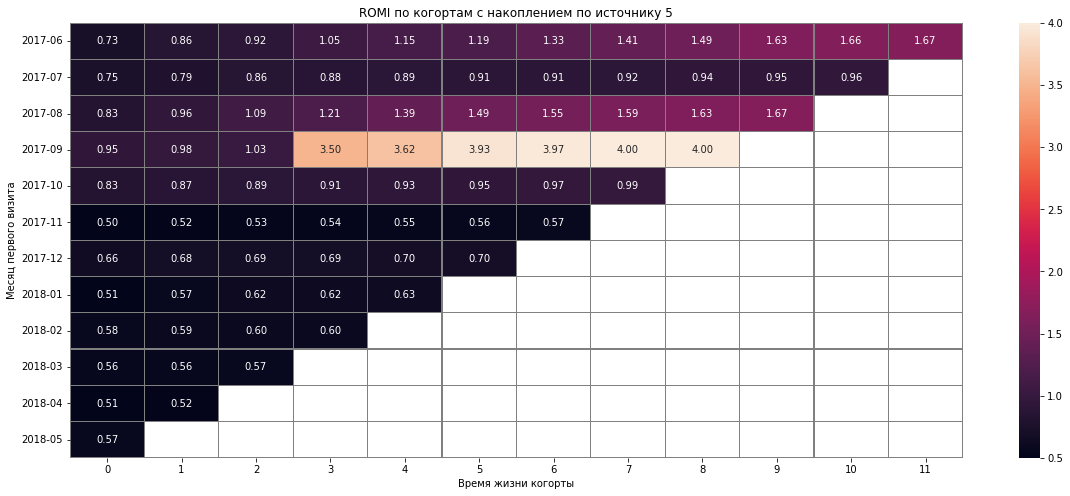

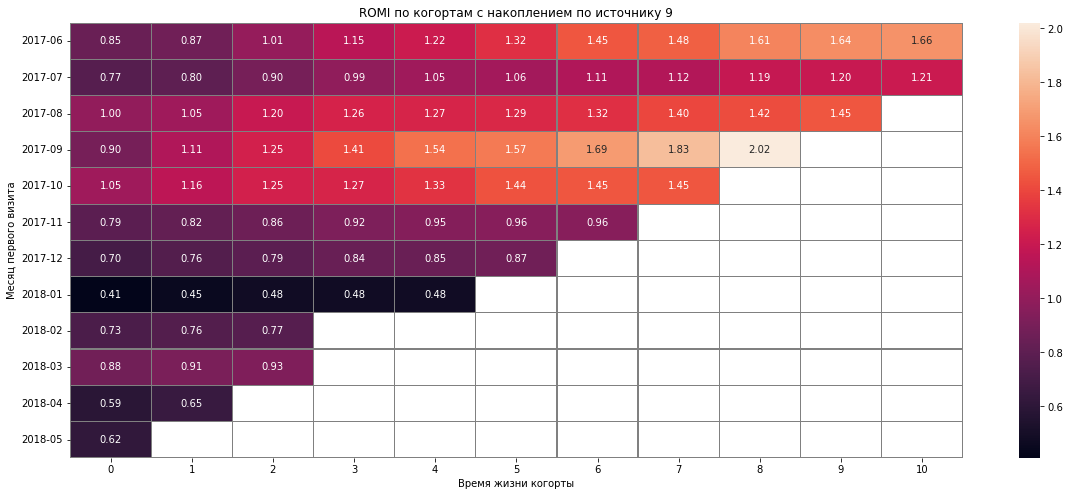

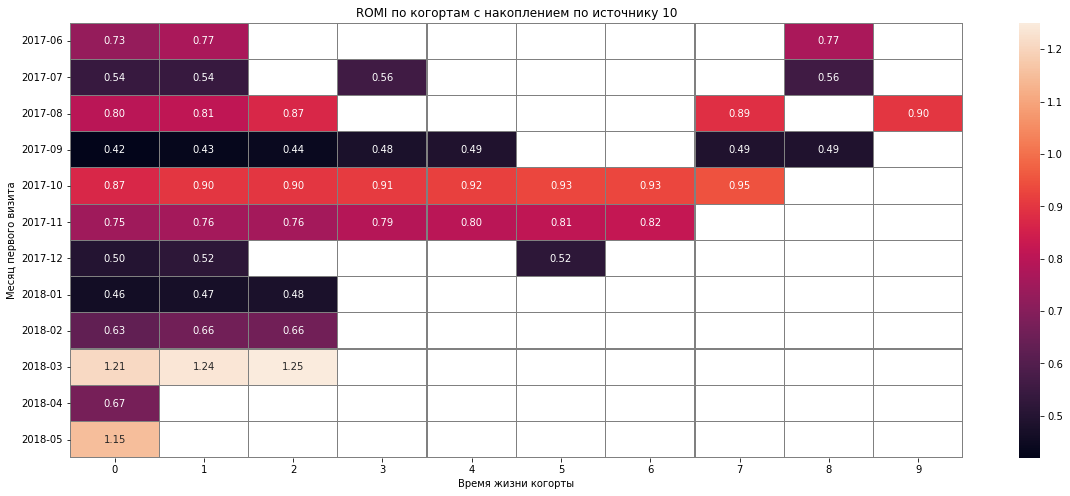

In [ ]:
for i in cohorts_new['source_id'].unique():
  romi(i)

In [ ]:
for i in cohorts_new['source_id'].unique():
  output = cohorts_new.loc[cohorts_new.source_id == i].pivot_table(
      index='first_order_month', columns='cohort_lifetime', values='romi', aggfunc='mean').cumsum(axis=1).round(2)
  print('ROMI по источнику трафика', i, ":", round(output.mean(axis=0), 3))

ROMI по источнику трафика 1 : cohort_lifetime
0     0.893
1     1.048
2     1.258
3     1.363
4     1.565
5     1.770
6     2.038
7     2.362
8     2.860
9     3.463
10    4.260
11    5.680
dtype: float64
ROMI по источнику трафика 2 : cohort_lifetime
0     0.549
1     0.631
2     0.777
3     0.939
4     1.085
5     1.229
6     1.032
7     1.142
8     1.218
9     0.993
10    1.290
11    1.610
dtype: float64
ROMI по источнику трафика 3 : cohort_lifetime
0     0.337
1     0.357
2     0.366
3     0.381
4     0.396
5     0.411
6     0.422
7     0.444
8     0.452
9     0.433
10    0.480
11    0.470
dtype: float64
ROMI по источнику трафика 4 : cohort_lifetime
0     0.757
1     0.775
2     0.791
3     0.816
4     0.842
5     0.901
6     0.982
7     0.900
8     0.908
9     0.953
10    1.165
11    1.420
dtype: float64
ROMI по источнику трафика 5 : cohort_lifetime
0     0.665
1     0.718
2     0.780
3     1.111
4     1.232
5     1.390
6     1.550
7     1.782
8     2.015
9     1.417
10    1.310
11

ВЫВОД

* При достаточно низкой стоимости привлечения клиентов по источнику 1, ROMI выходит за 1 в среднем уже на 2 месяц - это лучший средний показатель в разрезе источнков. Однако, можно отметить, что в 2018 году, за исключением когорты 03-2018, показатели ухудшаются. Стоит обратить внимание на этот источник.

* Привлечение клиентов через 2 источник обходился компании очень дорого. При средних маркетинговых расходах, САС очень высокая, а окупаемость в среднем наступает на 4-5 месяц. Отдельный успех был в когортах 09 и 12-2017 - этих клиентов стоит постараться удержать. Показатели начала 2018 года заметно ниже, чем в 2017.
Выделяется когорта 05-2018: САС резко снизился при сопоставимых маркетинговых расходах, значит, пришло достаточно много новых клиентов. Поэтому за этим источником необходимо понаблюдать, он может оказаться перспективным. 

Больше всего денег было вложено в 3,4 и 5 источники трафика, особенно, в 3: 
* Из-за этого ни одна когорта источника 3 не вышла на окупаемость даже через год. А САС (стоимость привлечения) по источникам одна из самых высоких. Поэтому вкладывать средства в этот канал считаю нерациональным.

* В целом, когорты 4 источника не выходят на окупаемость(за исключением 06-2017 и 11-2017).
В ноябре 2017 затраты на источник были снижены, поэтому приклеченные через этот канал клиенты сразу вышли на окупаемость (ROMI = 1.12). На фоне снижающихся маркетинговых расходов, ROMI имеет шанс перейти через 1 для последних когорт (с 03-2018 по 05-2018) к 4-5 месяцу.

* Среднестатистически, клиенты из 5 источника выходят на окупаемость на 4 месяц. Однако, если посмотреть на распределение, данное значение достигнуто только из-за отдельного успеха когорты 09-2017 (ROMI = 3.5). На этих "сентябрьских" клиентов стоит обратить внимание и, возможно, включить в программу лояльности, чтобы удержать их на сайте: почти сразу их привлечение принесло окупаемость (ROMI = 0.95 в первый месяц), ROMI[4 мес] = 3.5, ROMI[8 мес] = 4 - это абсолютный успех на данной выборке.
За последние 8 месяцев только одна когорта (10-2017) приблизилась к окупаемости (ROMI[8 мес] = 0.99), даже на фоне снижающихся маркетинговых расходов.

* На источники 9 и 10 почти не выделяется бюджет, в том числе поэтому САС по ним самый низкий, а ROMI для 9 источника очень привлекателен: окупаемость на 3-4 месяце (для 10 источника данных для выводов недостаточно). Все же, как и у ряда других источников, конец 2017 года и на этой площадке был гораздо успешнее, чем 2018. Возможно, все связано с сезонностью покупок.

ОБЩИЙ ВЫВОД

1. Общая сумма расходов на маркетинг составила 329131.62 у.е.

Явный фаворит у маркетологов - источник 3. На него, по-видимму, сделаны ставки и проведены активные траты с сентября по декабрь. 
Источники 9 и 10 не поддерживались отдельно. Бюджет на них практически не расходуется.

Исходя из выводов выше, маркетологам стоит обратить внимание на источники 1 и 9, понаблюдать за 2 источником. По источнику 3 абсолютно точно снизить расходы - они не оправдываются.

2. Расчет продуктовых метрик за весь период наблюдений показал:
* DAU = 907
* WAU = 5724
* MAU = 23228
* среднее число сессий в день для уникального пользователя составило 1.082 раз в день

С сентября 2017 по апрель 2018 количество посещений сайта значительно увеличилось. Пиковая активность зафиксирована в предновогоднее время.

3. В основном визиты очень короткие: всего 5 мин проводят пользователи на сайте.
Постоянных пользователей совсем немного: уже на второй месяц возвращается 6.5% покупателей. Кажется, что раньше пользователям больше нравился сервис: клиенты из более старых когорт 2017 возвращались чаще и коэф.удержания для них на 6 месяце жизни сравним с коэф.удержания новых клиентов из когорт 2018.

Чаще всего с момента первого посещения сайта до совершения покупки проходит 1 день.

Можно отметить, что чуть больше, чем обычно, когорты 06-2017, 08-11.2017 возвращались за билетами, особенно, перед новым годом, после чего активность затухала.

4. Как уже отмечалось, в декабре, перед новым годом, и посещений сайта, и покупок было больше, чем обычнно. Вырос и средний чек. Все это скомпенсировалсь экономией в январе.
Самой активной когортой можно назвать покупателей, пришедших в июне 2016. Однако, рассчитав LTV, видим, что покупатели 09-2017 принесли сервису куда больше прибыли уже к декабрю 2017, чем когорта 06-2017. Они же быстрее всего растут по показателю LTV.
Клиенты, пришедшие в декабре (12-2017), вернулись с прибылью в феврале и марте). Учитывая факт того, что в среднем товаров было куплено примерно столько же, а RR даже несколько снизился, значит, суммы покупок стали больше.


В среднем, по изученным показателям, когорты покупателей, пришедших в июне и сентябре 2017, самые активные и платежеспособные. Их стоит постараться удежать. Максимальный рост суммарной прибыли по когортам показывают клиенты с 09 по 12-2017. Когорта 03-2018 также может оказаться перспективной.
